<a href="https://colab.research.google.com/github/Hee0305/DL/blob/main/py-tensorflow/DL3-TL/TL_fine_tuning_mobilenetV2_cifar10pct100_Functional_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning and Visualization (CNN's)
- cifar-10
- resnet50
- mobilenetV2

> https://medium.com/@andrew.dabydeen/transfer-learning-using-resnet50-and-cifar-10-6242ed4b4245

### Transfer learning (imagenet)
- ImageNet dataset 
    - 1.4 million labeled images 
    - 1,000 different classes  
    
tensorflow.keras.applications
- Xception
- Inception V3
- ResNet50
- VGG16
- VGG19
- MobileNet

> [ref1-architecture-comparison-of-alexnet-vggnet-resnet-inception-densenet](https://towardsdatascience.com/architecture-comparison-of-alexnet-vggnet-resnet-inception-densenet-beb8b116866d)

> [ref2-imagenet-vggnet-resnet-inception-xception-keras](https://www.pyimagesearch.com/2017/03/20/imagenet-vggnet-resnet-inception-xception-keras/)

This Colab notebook demonstrates transfer learning with a pretrained ConvNet: MobileNetV2

0.   Data pipeline
1.   Baseline model: train a simple CNN from scratch
2.   Transfer learning: pretraiend ConvNet as a feature extractor
3.   Transfer learning: fine-tune a pretrained ConvNet
4.   Test accuracy & visualize predictions



Before beginning, let's load the appropriate libraries needed for this notebook

# ConvNet: MobileNetV2

In [1]:
# from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.applications.mobilenet_v2 import  MobileNetV2, preprocess_input
import tensorflow.keras as keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from keras.utils import np_utils
from keras.models import load_model
from keras.datasets import cifar10
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
# import cv2
print(tf.__version__)

2.7.0


In [2]:
tf.keras.backend.clear_session()  # For memory

# GPU check
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print("#### ", len(gpus), "Physical GPUs,",
                 len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
else:
    print('#### No CUDA supported GPU in this computer.')

####  1 Physical GPUs, 1 Logical GPUs


## Load data 
- Use total data

In [3]:
from keras.datasets import cifar10
# load dataset
(trainX, trainy), (testX, testy) = cifar10.load_data()
# summarize loaded dataset
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))

170508288/170498071 [==============================] - 8s 0us/step
Train: X=(50000, 32, 32, 3), y=(50000, 1)
Test: X=(10000, 32, 32, 3), y=(10000, 1)


---

### Visualize Dataset

Use the `display_images` to view some of the images and their class labels.

In [4]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [5]:
import os
# Matplotlib config
# plt.rc('image', cmap='gray')
plt.rc('grid', linewidth=0)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='000000')
plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")

# utility to display a row of digits with their predictions
def display_images(digits, predictions, labels, title):

  n = 10

  indexes = np.random.choice(len(predictions), size=n)
  n_digits = digits[indexes]
  n_predictions = predictions[indexes]
  n_predictions = n_predictions.reshape((n,))
  n_labels = labels[indexes]
 
  fig = plt.figure(figsize=(20, 4))
  plt.title(title)
  plt.yticks([])
  plt.xticks([])

  for i in range(10):
    ax = fig.add_subplot(1, 10, i+1)
    class_index = n_predictions[i]
    true_index = n_labels[i]
    # Set x-label color: green if prediction correct and red if prediction incorrect
    plt.xlabel(classes[class_index])
    xlabel_color = "green" if n_predictions[i] == n_labels[i] else "red"
    ax.xaxis.label.set_color(xlabel_color) 
    plt.xticks([])
    plt.yticks([])
    plt.imshow(n_digits[i])


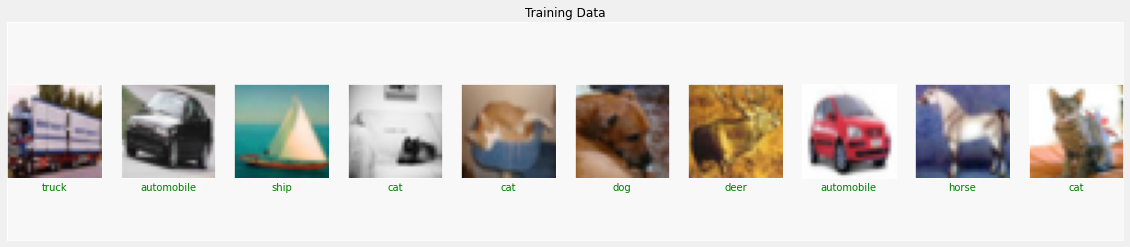

In [6]:
display_images(trainX, trainy, trainy, "Training Data" )

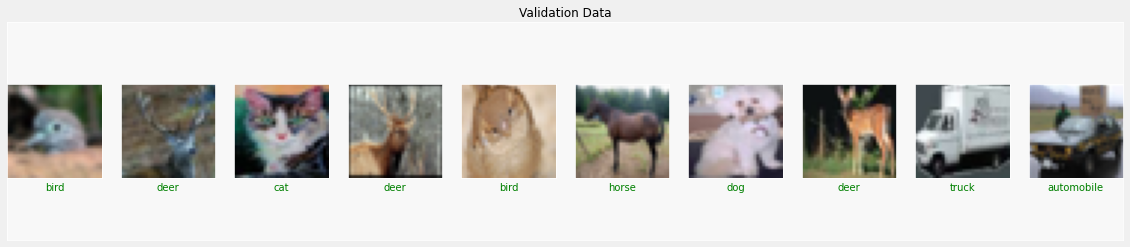

In [7]:
display_images(testX, testy, testy, "Validation Data" )

## *Preprocess the dataset*

In [8]:
def preprocess_image_input(input_images):
  input_images = input_images.astype('float32')
  output_ims = preprocess_input(input_images)
  return output_ims


In [9]:
x_train = preprocess_image_input(trainX)
x_test = preprocess_image_input(testX)

In [10]:
x_train.shape,len(x_train),x_train[4].shape

((50000, 32, 32, 3), 50000, (32, 32, 3))

In [11]:
y_train=trainy
y_test=testy
y_train.shape,y_test.shape

((50000, 1), (10000, 1))

## Transfer learning 

Now let's see how transfer learning can help achieve better results.

- Feature extractor

> Use MobileNetV2 as a feature extractor and add a classifier on top of it.

## Define the Network
We will be performing transfer learning on **MobileNetV2** available in Keras.
- We'll load pre-trained **imagenet weights** to the model.
- We'll choose to retain all layers of **MobileNetV2** along with the final classification layers.

In [12]:
'''
Feature Extraction is performed by MobileNetV2 pretrained on imagenet weights. 
Input size is 224 x 224.
'''
def feature_extractor(inputs):  #특징을 뽑아내기에 이름을 feature_extractor로 붙임

  TL_base = MobileNetV2(input_shape=(224, 224, 3),
                                               include_top=False,   #FCN 단계를 빼고CNN단계만
                                               weights='imagenet')
  #   Unfreeze top layers for fine tuning
  TL_base.trainable = False
  return TL_base(inputs)


'''
Defines final dense layers and subsequent softmax layer for classification.
'''
def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Flatten()(x)    #Flatten하여 벡터로 바꿈
    x = tf.keras.layers.Dense(1024, activation="relu")(x)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    x = tf.keras.layers.Dense(10, activation="softmax", name="classification")(x)
    return x

'''
Since input image size is (32 x 32), first upsample the image by factor of (7x7) to transform it to (224 x 224)
Connect the feature extraction and "classifier" layers to build the model.
'''
def final_model(inputs):

    resize = tf.keras.layers.UpSampling2D(size=(7,7))(inputs)

    resnet_feature_extractor = feature_extractor(resize)
    classification_output = classifier(resnet_feature_extractor)

    return classification_output

'''
Define the model and compile it. 
Use Stochastic Gradient Descent as the optimizer.
Use Sparse Categorical CrossEntropy as the loss function.
'''
def define_compile_model():
  inputs = tf.keras.layers.Input(shape=(32,32,3))
  
  classification_output = final_model(inputs) 
  model = tf.keras.Model(inputs=inputs, outputs = classification_output)
 
  model.compile(optimizer='SGD', 
                loss='sparse_categorical_crossentropy',  # y_train is NOT one-hot encoded!
                metrics = ['accuracy'])
  
  return model


model = define_compile_model()

model.summary()

9420800/9406464 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 1280)              0        

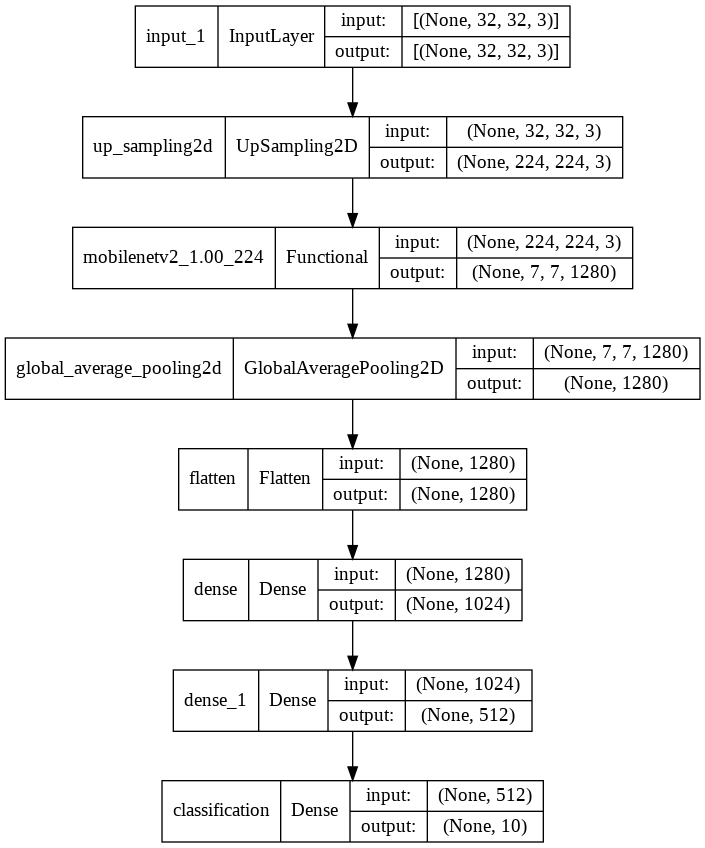

In [13]:
# Plot model
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model_F.png')

In [14]:
from tensorflow.keras import layers, models, callbacks

In [15]:
mc_callback = callbacks.ModelCheckpoint(filepath="./model/cifar10pct100_mobileNetV2F_SGD_best_weights.{epoch:03d}-{val_accuracy:.3f}.hdf5", 
                              monitor='val_accuracy', verbose=0, save_best_only=True)
es_callback = callbacks.EarlyStopping(monitor='val_accuracy', 
                            mode='max', verbose=1, patience=5)

## Train the model

In [16]:
%%time
EPOCHS = 100
BATCH_SIZE = 50  # 32, 50, 64, 100
history = model.fit(x_train, y_train, 
                    epochs=EPOCHS, 
                    validation_data = (x_test, y_test), 
                    batch_size=BATCH_SIZE,
                    callbacks=[mc_callback,es_callback])

Epoch 1/100
1000/1000 [==============================] - ETA: 0s - loss: 1.1283 - accuracy: 0.6114

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


1000/1000 [==============================] - 153s 141ms/step - loss: 1.1283 - accuracy: 0.6114 - val_loss: 0.9576 - val_accuracy: 0.6648
Epoch 2/100
1000/1000 [==============================] - 159s 159ms/step - loss: 0.8719 - accuracy: 0.6939 - val_loss: 0.8475 - val_accuracy: 0.7058
Epoch 3/100
1000/1000 [==============================] - 159s 159ms/step - loss: 0.7990 - accuracy: 0.7202 - val_loss: 0.8190 - val_accuracy: 0.7123
Epoch 4/100
1000/1000 [==============================] - 159s 159ms/step - loss: 0.7504 - accuracy: 0.7381 - val_loss: 0.7691 - val_accuracy: 0.7284
Epoch 5/100
1000/1000 [==============================] - 159s 159ms/step - loss: 0.7142 - accuracy: 0.7497 - val_loss: 0.7333 - val_accuracy: 0.7447
Epoch 6/100
1000/1000 [==============================] - 159s 159ms/step - loss: 0.6824 - accuracy: 0.7602 - val_loss: 0.7321 - val_accuracy: 0.7456
Epoch 7/100
1000/1000 [==============================] - 159s 159ms/step - loss: 0.6584 - accuracy: 0.7690 - val_loss:

## Evaluate the Model

Calculate the loss and accuracy metrics using the model's `.evaluate` function.

In [17]:
model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)

200/200 [==============================] - 23s 116ms/step - loss: 0.6821 - accuracy: 0.7718


[0.6821063756942749, 0.7717999815940857]

## 훈련 데이터와 검증 데이터에 대한 loss, accuracy 시각화

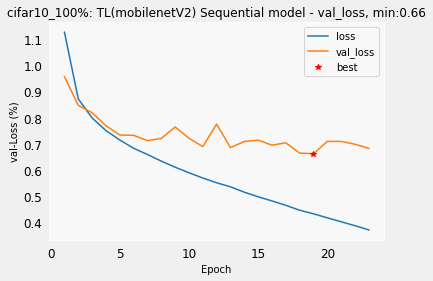

In [18]:
# 훈련 데이터와 검증 데이터에 대한 loss 시각화.
epochs = range(1, len(history.history['loss']) + 1)

loss_list = history.history['loss'] #[100 * i for i in history.history['loss']]
vloss_list = history.history['val_loss'] #[100 * i for i in history.history['val_loss']]

plt.plot(epochs,loss_list)  
plt.plot(epochs,vloss_list)

plt.plot(np.argmin(np.array(vloss_list))+1,vloss_list[np.argmin(np.array(vloss_list))], 'r*')
plt.title('cifar10_100%: TL(mobilenetV2) Sequential model - val_loss, min:' + str(np.round(vloss_list[np.argmin(np.array(vloss_list))],2)))
plt.ylabel('val-Loss (%)')
plt.xlabel('Epoch')
plt.legend(['loss','val_loss','best'], loc='best')
plt.show()

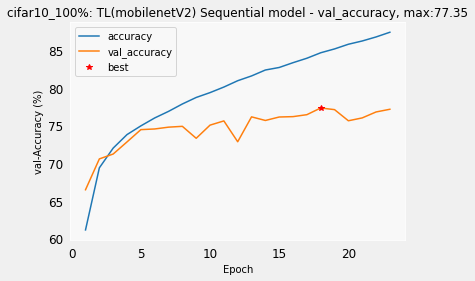

In [19]:
# 훈련 데이터와 검증 데이터에 대한 accuracy 시각화.
epochs = range(1, len(history.history['accuracy']) + 1)

acc_list = [100 * i for i in history.history['accuracy']]
vacc_list = [100 * i for i in history.history['val_accuracy']]

plt.plot(epochs,acc_list)  
plt.plot(epochs,vacc_list)

plt.plot(np.argmax(np.array(vacc_list))+1,vacc_list[np.argmax(np.array(vacc_list))], 'r*')
plt.title('cifar10_100%: TL(mobilenetV2) Sequential model - val_accuracy, max:' + str(np.round(vacc_list[np.argmax(np.array(vacc_list))],2)))
plt.ylabel('val-Accuracy (%)')
plt.xlabel('Epoch')
plt.legend(['accuracy','val_accuracy','best'], loc='best')
plt.show()

### Visualization loss & accuracy

The training/validation loss and accuracy visualizations are shown below

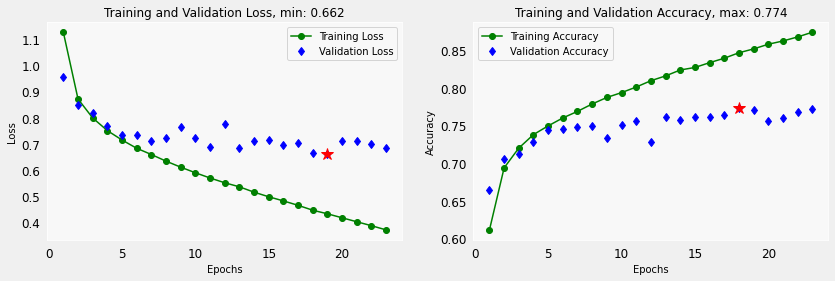

In [20]:
# More graphs of loss and accuracy
history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(14, 4))

plt.subplot(1,2,1)
plt.plot(epochs, loss, 'go-', label='Training Loss')
plt.plot(epochs, val_loss, 'bd', label='Validation Loss')
plt.plot(np.argmin(np.array(val_loss))+1,val_loss[np.argmin(np.array(val_loss))], 'r*', ms=12)
plt.title('Training and Validation Loss, min: ' + str(np.round(val_loss[np.argmin(np.array(val_loss))],3)))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

epochs = range(1, len(loss) + 1)

plt.subplot(1,2,2)
plt.plot(epochs, acc, 'go-', label='Training Accuracy') #, c='blue')
plt.plot(epochs, val_acc, 'bd', label='Validation Accuracy') #, c='red')
plt.plot(np.argmax(np.array(val_acc))+1,val_acc[np.argmax(np.array(val_acc))], 'r*', ms=12)
plt.title('Training and Validation Accuracy, max: ' + str(np.round(val_acc[np.argmax(np.array(val_acc))],3)))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Visualize predictions
We can take a look at the predictions on the validation set.

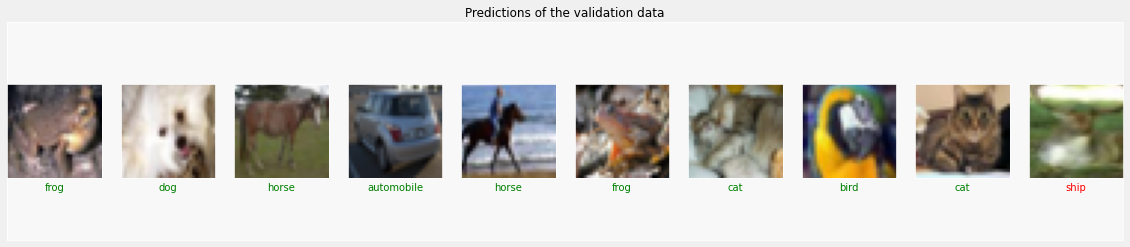

In [21]:
probabilities = model.predict(x_test, batch_size=BATCH_SIZE)
probabilities = np.argmax(probabilities, axis = 1)

display_images(testX, probabilities, testy, "Predictions of the validation data")

---

# **Fine tuning**

In [22]:
tf.keras.backend.clear_session()  # For memory

In [23]:
'''
Feature Extraction is performed by MobileNetV2 pretrained on imagenet weights. 
Input size is 224 x 224.
'''
def feature_extractor_fine_tuning(inputs):

  TL_base = MobileNetV2(input_shape=(224, 224, 3),
                            include_top=False,
                            weights='imagenet')
#   Unfreeze top layers for fine tuning
  TL_base.trainable = True
  # Fine-tune from this layer onwards
  fine_tune_at = 107

  # Freeze all the layers before the `fine_tune_at` layer
  for layer in TL_base.layers[:fine_tune_at]:   #107번 이후 부터
    layer.trainable =  False

  return TL_base(inputs)

def final_model_ft(inputs):

    resize = tf.keras.layers.UpSampling2D(size=(7,7))(inputs)

    fine_feature_extractor = feature_extractor_fine_tuning(resize)
    classification_output = classifier(fine_feature_extractor)

    return classification_output

def define_compile_model_ft():
  inputs = tf.keras.layers.Input(shape=(32,32,3))
  
  classification_output = final_model_ft(inputs) 
  model = tf.keras.Model(inputs=inputs, outputs = classification_output)
 
  model.compile(optimizer='SGD', 
                loss='sparse_categorical_crossentropy',  # y_train is NOT one-hot encoded!
                metrics = ['accuracy'])
  
  return model

model = define_compile_model_ft()

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                             

In [24]:
from tensorflow.keras import layers, models, callbacks

In [25]:
mc_callback = callbacks.ModelCheckpoint(filepath="./model/cifar10pct100_mobileNetV2F_SGD_FT_best_weights.{epoch:03d}-{val_accuracy:.3f}.hdf5", 
                              monitor='val_accuracy', verbose=0, save_best_only=True)
es_callback = callbacks.EarlyStopping(monitor='val_accuracy', 
                            mode='max', verbose=1, patience=5)

## Train the fine-tuned model

In [26]:
INITIAL_EPOCHS = len(loss)
FINE_TUNE_EPOCHS = 100
TOTAL_EPOCHS = INITIAL_EPOCHS + FINE_TUNE_EPOCHS #

In [27]:
%%time
BATCH_SIZE = 50  # 32, 50, 64, 100
history_fine = model.fit(x_train, y_train, 
                    epochs=TOTAL_EPOCHS, 
                    initial_epoch=INITIAL_EPOCHS,
                    validation_data = (x_test, y_test), 
                    batch_size=BATCH_SIZE,
                    callbacks=[mc_callback,es_callback])

Epoch 24/123
1000/1000 [==============================] - ETA: 0s - loss: 0.6609 - accuracy: 0.7753

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


1000/1000 [==============================] - 190s 186ms/step - loss: 0.6609 - accuracy: 0.7753 - val_loss: 1.0680 - val_accuracy: 0.6375
Epoch 25/123
1000/1000 [==============================] - 204s 204ms/step - loss: 0.3136 - accuracy: 0.8916 - val_loss: 0.5333 - val_accuracy: 0.8228
Epoch 26/123
1000/1000 [==============================] - 204s 204ms/step - loss: 0.1917 - accuracy: 0.9349 - val_loss: 0.3898 - val_accuracy: 0.8717
Epoch 27/123
1000/1000 [==============================] - 204s 204ms/step - loss: 0.1137 - accuracy: 0.9617 - val_loss: 0.4345 - val_accuracy: 0.8700
Epoch 28/123
1000/1000 [==============================] - 185s 185ms/step - loss: 0.0691 - accuracy: 0.9777 - val_loss: 0.4952 - val_accuracy: 0.8660
Epoch 29/123
1000/1000 [==============================] - 204s 204ms/step - loss: 0.0438 - accuracy: 0.9863 - val_loss: 0.4701 - val_accuracy: 0.8808
Epoch 30/123
1000/1000 [==============================] - 204s 204ms/step - loss: 0.0321 - accuracy: 0.9899 - val

## Evaluate the Model

Calculate the loss and accuracy metrics using the model's `.evaluate` function.

In [28]:
model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)

200/200 [==============================] - 23s 114ms/step - loss: 0.6204 - accuracy: 0.8856


[0.6204304099082947, 0.8855999708175659]

### Plot Loss and Accuracy Curves

Plot the loss (in blue) and validation loss (in green).

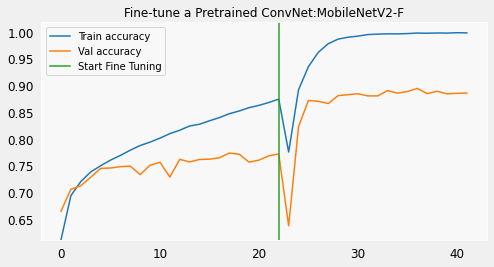

In [29]:
# Display training curve

acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']

plt.figure(figsize=(8, 4))

plt.plot(acc, label='Train accuracy')
plt.plot(val_acc, label='Val accuracy')
# plt.ylim([0.8, 1])
plt.plot([INITIAL_EPOCHS-1, INITIAL_EPOCHS-1], plt.ylim(ymin=acc[0]), label='Start Fine Tuning')
plt.title("Fine-tune a Pretrained ConvNet:MobileNetV2-F")
plt.legend(loc='upper left')

plt.show()

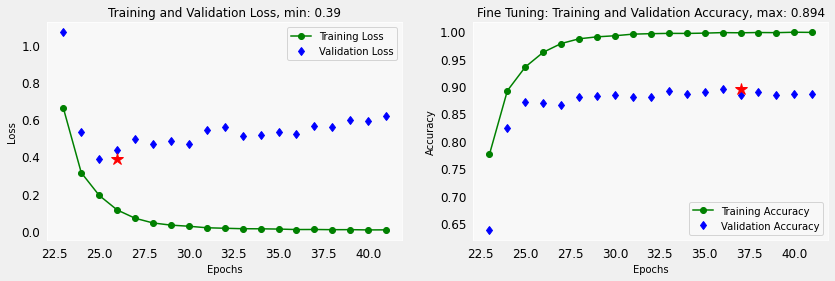

In [30]:
# More graphs of loss and accuracy in Fine Tuning
history_dict = history_fine.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(INITIAL_EPOCHS, INITIAL_EPOCHS+len(loss))

plt.figure(figsize=(14, 4))

plt.subplot(1,2,1)
plt.plot(epochs, loss, 'go-', label='Training Loss')
plt.plot(epochs, val_loss, 'bd', label='Validation Loss')
plt.plot(INITIAL_EPOCHS + np.argmin(np.array(val_loss))+1,val_loss[np.argmin(np.array(val_loss))], 'r*', ms=12)
plt.title('Training and Validation Loss, min: ' + str(np.round(val_loss[np.argmin(np.array(val_loss))],3)))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

# epochs = range(1, len(loss_values) + 1)

plt.subplot(1,2,2)
plt.plot(epochs, acc, 'go-', label='Training Accuracy')#, c='blue')
plt.plot(epochs, val_acc, 'bd', label='Validation Accuracy') #, c='red')
plt.plot(INITIAL_EPOCHS + np.argmax(np.array(val_acc))+1,val_acc[np.argmax(np.array(val_acc))], 'r*', ms=12)
plt.title('Fine Tuning: Training and Validation Accuracy, max: ' + str(np.round(val_acc[np.argmax(np.array(val_acc))],3)))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Best model
- cifar10pct100_mobileNetV2F_SGD_FT_best_weights.037-0.889.hdf5

### Visualize predictions
We can take a look at the predictions on the validation set.

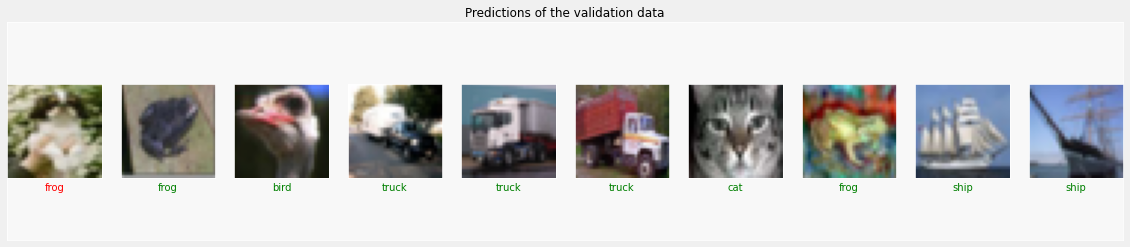

In [31]:
probabilities = model.predict(x_test, batch_size=BATCH_SIZE)
probabilities = np.argmax(probabilities, axis = 1)

display_images(testX, probabilities, testy, "Predictions of the validation data")

---

---

In [32]:
tf.keras.backend.clear_session()  # For memory